In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, QuantileTransformer


class SmartNormalizer:
    def __init__(self, two_col=False):
        self.quantile_transformer = None
        self.encoder = None
        self.two_col = two_col
        self.is_numeric = None

    def fit(self, data):
        assert type(data) == np.ndarray
        data = data.copy().ravel()
        self.is_numeric = data.dtype != np.dtype("O")
        if self.is_numeric:
            good_mask = np.isfinite(data)
            data = data[good_mask]
            if not len(data):
                data = np.zeros(1)
            data = data.reshape(-1, 1)
            self.quantile_transformer = QuantileTransformer(
                output_distribution="normal", n_quantiles=min(100, len(data))
            )
            self.quantile_transformer.fit(data)
        else:
            data = data.reshape(-1, 1)
            self.encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            )
            self.encoder.fit(data)

    def transform(self, data):
        data = data.copy().ravel()
        if self.is_numeric:
            good_mask = np.isfinite(data)
            data[~good_mask] = 0
            data = data.reshape(-1, 1)
            first_col = self.quantile_transformer.transform(data)
        else:
            good_mask = data != None
            data = data.reshape(-1, 1)
            first_col = self.encoder.transform(data)
        if self.two_col:
            second_col = good_mask.astype(np.float32).reshape(-1, 1)
            return np.concatenate([first_col, second_col], axis=1)
        else:
            return first_col.reshape(-1, 1)


class SmartNormalizerDF:
    def __init__(self, two_col=False):
        self.two_col = two_col
        self.normalizers = {}

    def fit(self, df):
        for col in df.columns:
            self.normalizers[col] = SmartNormalizer(self.two_col)
            self.normalizers[col].fit(df[col].values)

    def transform(self, df):
        df = df.copy()
        for i, col in enumerate(df.columns):
            if self.two_col:
                df[[col, col + "_ok"]] = self.normalizers[col].transform(df[col].values)
            else:
                df[col] = self.normalizers[col].transform(df[col].values)
            if i % 10 == 0:
                df = df.copy()
        return df


In [15]:
target_col = "label"  # "status"
ok_val = 1  # "OK"
important_columns = [
    "s8_sensor100_millimeter_step1",
    "shift",
    "weekday",
    "s4_sensor16_minuten (zeit)_step1",
    "s5_sensor0_sekunden (zeit)_step1",
    "s10_sensor2_gramm_step1",
    "s3_sensor0_km_step1",
    "s7_sensor26_mikroohm_step1",
    "s8_sensor32_millimeter_step1",
    "s10_sensor0_minuten (zeit)_step1",
]


In [16]:
df = pd.read_csv("train.csv").drop(columns=["message_timestamp", "physical_part_id"])
target = df[target_col] == ok_val
df = df.drop(columns=[target_col])
df = df[important_columns]
df_train = df.sample(frac=0.8)
df_valid = df.drop(df_train.index)

smart_normalizer = SmartNormalizerDF(two_col=True)
smart_normalizer.fit(df_train)
df_train = smart_normalizer.transform(df_train)
target_train = target[df_train.index]
df_valid = smart_normalizer.transform(df_valid)
target_valid = target[df_valid.index]


In [17]:
print(target_train.mean(), target_valid.mean())
print(target_train.shape, target_valid.shape)


0.9492701974030804 0.9491756538985993
(32269,) (8067,)


In [18]:
df_train.head()


,s8_sensor100_millimeter_step1,shift,weekday,s4_sensor16_minuten (zeit)_step1,s5_sensor0_sekunden (zeit)_step1,s10_sensor2_gramm_step1,s3_sensor0_km_step1,s7_sensor26_mikroohm_step1,s8_sensor32_millimeter_step1,s10_sensor0_minuten (zeit)_step1,s8_sensor100_millimeter_step1_ok,shift_ok,weekday_ok,s4_sensor16_minuten (zeit)_step1_ok,s5_sensor0_sekunden (zeit)_step1_ok,s10_sensor2_gramm_step1_ok,s3_sensor0_km_step1_ok,s7_sensor26_mikroohm_step1_ok,s8_sensor32_millimeter_step1_ok,s10_sensor0_minuten (zeit)_step1_ok
12085,-0.904986,2.0,3.0,-1.194396,-0.018569,-0.535083,-1.985058,1.399657,-0.574460,1.886265,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25719,-2.327324,1.0,1.0,-0.530220,-0.034610,0.139710,0.205808,-0.635270,-2.181535,-5.199338,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38105,-0.589456,2.0,3.0,0.416878,0.030071,0.877028,-1.683119,-1.876359,-1.168949,0.584443,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75,-0.801766,1.0,0.0,-0.889495,-0.000791,-1.073988,-1.358698,-0.063341,0.269066,-5.199338,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3740,0.784238,2.0,5.0,-0.139710,1.147574,-0.237938,-0.396252,-0.335333,0.358864,-0.430727,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()
model.fit(df_train, target_train, eval_set=(df_valid, target_valid), verbose=10)


Learning rate set to 0.074744
0:	learn: 0.5965709	test: 0.5967447	best: 0.5967447 (0)	total: 4.76ms	remaining: 4.75s
10:	learn: 0.2446994	test: 0.2459869	best: 0.2459869 (10)	total: 43.8ms	remaining: 3.93s
20:	learn: 0.1966748	test: 0.1990965	best: 0.1990965 (20)	total: 79.1ms	remaining: 3.69s
30:	learn: 0.1838015	test: 0.1875987	best: 0.1875987 (30)	total: 117ms	remaining: 3.66s
40:	learn: 0.1772923	test: 0.1827385	best: 0.1827268 (39)	total: 157ms	remaining: 3.67s
50:	learn: 0.1732191	test: 0.1800070	best: 0.1800070 (50)	total: 195ms	remaining: 3.63s
60:	learn: 0.1705392	test: 0.1788059	best: 0.1788059 (60)	total: 265ms	remaining: 4.08s
70:	learn: 0.1681140	test: 0.1777272	best: 0.1777187 (69)	total: 305ms	remaining: 3.99s
80:	learn: 0.1661850	test: 0.1770398	best: 0.1770398 (80)	total: 345ms	remaining: 3.91s
90:	learn: 0.1643622	test: 0.1764809	best: 0.1764809 (90)	total: 385ms	remaining: 3.85s
100:	learn: 0.1629526	test: 0.1761683	best: 0.1761683 (100)	total: 422ms	remaining: 3.75s

In [26]:
# Show feature importance
importances = model.get_feature_importance()
feature_names = model.feature_names_
sorted_idx = importances.argsort()[::-1]
all_results = [
    (feature_names[sorted_idx[i]], importances[sorted_idx[i]])
    for i in range(len(feature_names))
    # if "_ok" in feature_names[sorted_idx[i]]
]
# for name, imp in all_results[:30]:
#     print(f"{name}: {imp}")

top_features = [name for name, imp in all_results[:10]]
print(top_features)


['s4_sensor16_minuten (zeit)_step1', 's8_sensor100_millimeter_step1', 's5_sensor0_sekunden (zeit)_step1', 'shift', 'weekday', 's10_sensor2_gramm_step1', 's8_sensor32_millimeter_step1', 's10_sensor0_minuten (zeit)_step1', 's7_sensor26_mikroohm_step1', 's3_sensor0_km_step1']


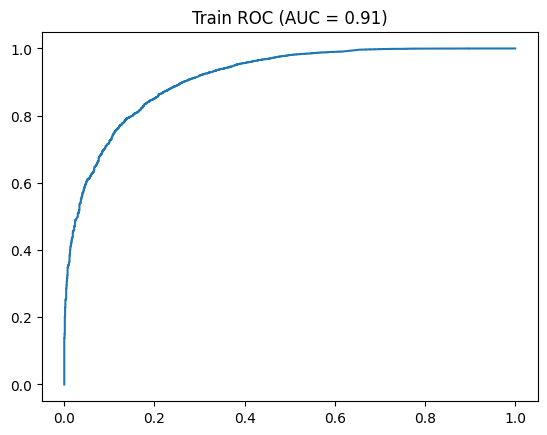

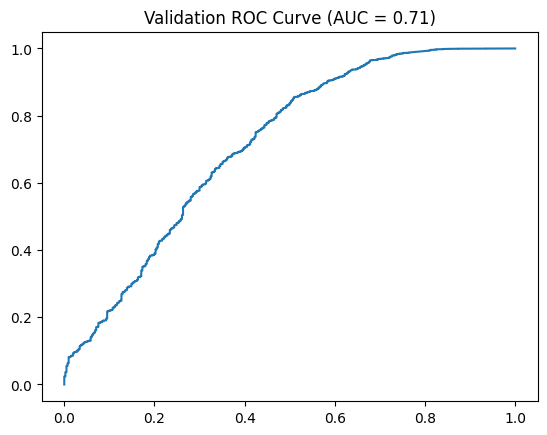

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred = model.predict_proba(df_train)[:, 1]
fpr, tpr, thresholds = roc_curve(target_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Train ROC (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()

y_pred = model.predict_proba(df_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Validation ROC Curve (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()


In [24]:
test_df = pd.read_csv("test.csv").drop(
    columns=["message_timestamp", "physical_part_id"]
)
test_df = test_df[top_features]
test_df = smart_normalizer.transform(test_df)
y_pred = model.predict_proba(test_df)[:, 1]
print(y_pred.shape)
print(y_pred[:10])


(4482,)
[0.97479686 0.95429407 0.95674184 0.97737801 0.9747036  0.97666518
 0.75348261 0.97541177 0.99240371 0.94030154]


In [25]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["label"] = y_pred
sample_submission.to_csv("submission.csv", index=False)
